# Dependency Parsing with Eisner
Par Louis GERARD & Tiago CORTINHAL

In [1]:
import sys
venv_root = '/var/lib/vz/data/g13005245/DEEP/'
sys.path.append(venv_root + 'lib/python3.5/site-packages')

import warnings
warnings.filterwarnings('ignore')

import utils
import f1
import f2
import f3

import time
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.models import Word2Vec

Using TensorFlow backend.


## Features 1

We start building a model on these features :
- Governor POS
- Dependant POS
- Distance between these words

### Read data

We read the conllu file to get aall the info we need. In order to make this reusable, we can add any feature to the final list by adding its index to `features_enabled`. Here we have :
- the index, to identify our token
- the part of speech, which we want to pass to our model
- the governor index, to build pairs

In [2]:
sentence = f1.sentences_fr_train[3]
pd.DataFrame(sentence)

,0,1,2,3
0,0,ROOT,0,root
1,1,ADV,5,advmod
2,2,PUNCT,5,punct
3,3,DET,4,det
4,4,NOUN,5,nsubj
5,5,VERB,0,root
6,6,DET,7,det
7,7,NOUN,5,obj
8,8,PUNCT,5,punct


### Projectivity

In [3]:
counter_p, proportion_p = utils.count_projectives(f1.sentences_fr_train, f1)
counter_p, '%.2f %%' % proportion_p

(1169, '8.03 %')

In [4]:
counter_p, proportion_p = utils.count_projectives(f1.sentences_fr_dev, f1)
counter_p, '%.2f %%' % proportion_p

(113, '7.65 %')

In [5]:
counter_p, proportion_p = utils.count_projectives(f1.sentences_fr_test, f1)
counter_p, '%.2f %%' % proportion_p

(18, '4.33 %')

### Creating dataset

Now we have all the data we need, we can process it to build our dataset. 

We can't pass directly the part of speech tags to our model, so we need to encod it to an one hot vector. We can compute the distances with the indexes. 

We can still reuse this code by adapting `index_i`, `pos_i` and `governor_i` to the previous final result and process the added data in `create_example()`. 

The targets are a bit simplitic because all we need to compute it is the distance. A single neuron with linear activation function, a weight of 1 for the distance and weights of 0 for the POS can do the job. 

#### Without negatives

In [6]:
x_train, y_train = utils.create_dataset(f1.sentences_fr_train, f1)
x_train.shape, y_train.shape

((356638, 37), (356638, 39))

In [7]:
x_test, y_test = utils.create_dataset(f1.sentences_fr_dev, f1)
x_test.shape, y_test.shape

((35768, 37), (35768, 39))

In [8]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(39, activation='sigmoid', input_dim=37))

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
opt = keras.optimizers.Adam(lr=0.0001)

model.compile(opt, 'binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 39)                1482      
Total params: 1,482
Trainable params: 1,482
Non-trainable params: 0
_________________________________________________________________


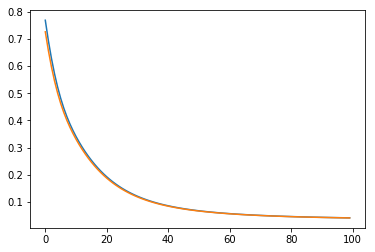

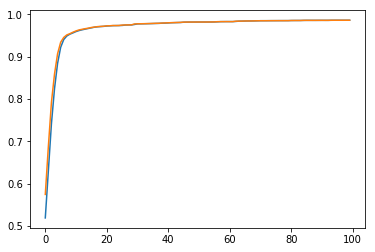

In [9]:
h = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), verbose=0, callbacks=[tensorboard])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

#### With negatives

In [10]:
x_train_n, y_train_n = utils.create_dataset(f1.sentences_fr_train, f1, with_negatives=True)
x_train_n.shape, y_train_n.shape

((713276, 37), (713276, 39))

In [11]:
x_test_n, y_test_n = utils.create_dataset(f1.sentences_fr_dev, f1, with_negatives=True)
x_test_n.shape, y_test_n.shape

((71536, 37), (71536, 39))

In [12]:
model_n = keras.models.Sequential()
model_n.add(keras.layers.Dense(39, activation='softplus', input_dim=37))

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
opt = keras.optimizers.Adam(lr=0.0001)

model_n.compile(opt, 'categorical_crossentropy', metrics=['accuracy'])
model_n.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 39)                1482      
Total params: 1,482
Trainable params: 1,482
Non-trainable params: 0
_________________________________________________________________


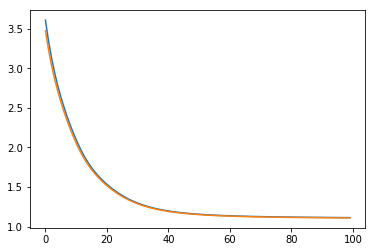

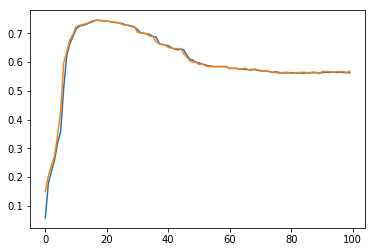

In [13]:
h = model_n.fit(x_train_n, y_train_n, epochs=100, batch_size=1024, validation_data=(x_test_n, y_test_n), verbose=0, callbacks=[tensorboard])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

#### Some tests

In [14]:
for s in sentence:
    print(s)
    x, _ = f1.create_example(s, sentence[int(s[f1.governor_i])])
    prediction = model.predict(x.reshape(1, -1))[0]
    prediction_n = model_n.predict(x.reshape(1, -1))[0]
    
    i2 = np.argmax(prediction[2:])
    label2 = utils.onehot_2_label[i2]
    print('Without negatives :', label2, prediction[i2+2], prediction[:2])

    i = np.argmax(prediction_n[2:])
    label = utils.onehot_2_label[i]
    print('With negatives :', label, prediction_n[i+2], prediction_n[:2], '\n')

['0' 'ROOT' '0' 'root']
Without negatives : root 0.88224316 [0.03511339 0.9664193 ]
With negatives : root 3.6725528 [1.3500871e-03 3.7072837e+00] 

['1' 'ADV' '5' 'advmod']
Without negatives : advmod 0.7101634 [0.9786618  0.02185597]
With negatives : advmod 1.4447548 [2.025219  0.0381541] 

['2' 'PUNCT' '5' 'punct']
Without negatives : punct 0.8922806 [0.9932201  0.00922837]
With negatives : punct 3.4273777 [3.1174378e+00 9.1498939e-04] 

['3' 'DET' '4' 'det']
Without negatives : det 0.94418514 [0.9816691  0.01944182]
With negatives : det 2.4116135 [2.4419026  0.00355386] 

['4' 'NOUN' '5' 'nsubj']
Without negatives : nsubj 0.23021573 [0.5621371 0.442794 ]
With negatives : nsubj 0.3129259 [0.7396461 0.5162035] 

['5' 'VERB' '0' 'root']
Without negatives : obl 0.5293122 [0.08915568 0.9012421 ]
With negatives : obl 1.9076493 [0.42443603 3.4828258 ] 

['6' 'DET' '7' 'det']
Without negatives : det 0.94418514 [0.9816691  0.01944182]
With negatives : det 2.4116135 [2.4419026  0.00355386] 

[

#### Eisner's algorithm

Now we have our model, we can use it to create the dependency parsing itself with Eisner's algorithm. 

[Explanatory video](https://youtu.be/du9VQaFEyeA)

In [15]:
full_left, full_right, part, labels = utils.eisner(sentence, f1, model=model)
full_left_n, full_right_n, part_n, labels_n = utils.eisner(sentence, f1, model=model_n)
true_full_left, true_full_right, true_part, true_labels = utils.eisner(sentence, f1, perfect=True)

#### Decomposition

In [16]:
sentence_predicted = utils.predict_sentence(sentence, f1, full_left, full_right, part, labels)
pd.DataFrame(sentence_predicted)

,0,1,2,3
0,0,ROOT,0,root
1,1,ADV,5,advmod
2,2,PUNCT,5,punct
3,3,DET,5,det
4,4,NOUN,5,nsubj
5,5,VERB,8,punct
6,6,DET,5,det
7,7,NOUN,5,obl
8,8,PUNCT,0,punct


In [17]:
utils.compare(pd.DataFrame(sentence_predicted)[[f1.governor_i, f1.label_i]], pd.DataFrame(sentence)[[f1.governor_i, f1.label_i]])

,2,3
0,True,True
1,True,True
2,True,True
3,False,True
4,True,True
5,False,False
6,False,True
7,True,False
8,False,True


In [18]:
sentence_predicted = utils.predict_sentence(sentence, f1, full_left_n, full_right_n, part_n, labels_n)
pd.DataFrame(sentence_predicted)

,0,1,2,3
0,0,ROOT,0,root
1,1,ADV,5,advmod
2,2,PUNCT,5,punct
3,3,DET,5,det
4,4,NOUN,5,nsubj
5,5,VERB,8,punct
6,6,DET,5,det
7,7,NOUN,5,obl
8,8,PUNCT,0,punct


In [19]:
utils.compare(pd.DataFrame(sentence_predicted)[[f1.governor_i, f1.label_i]], pd.DataFrame(sentence)[[f1.governor_i, f1.label_i]])

,2,3
0,True,True
1,True,True
2,True,True
3,False,True
4,True,True
5,False,False
6,False,True
7,True,False
8,False,True


### LAS scores

In [20]:
sentences_test = utils.predict_sentences('UD_French-GSD/fr_gsd-ud-test.conllu', f1, model=model)
utils.write_conllu(sentences_test, f1, 'UD_French-GSD/fr_gsd-ud-test.conllu', 'fr_test.conll')
utils.score_las('fr_test.conll', 'UD_French-GSD/fr_gsd-ud-test.conllu')

0.11127744510978044

In [21]:
sentences_test = utils.predict_sentences('UD_French-GSD/fr_gsd-ud-test.conllu', f1, model=model_n)
utils.write_conllu(sentences_test, f1, 'UD_French-GSD/fr_gsd-ud-test.conllu', 'fr_test_n.conll')
utils.score_las('fr_test_n.conll', 'UD_French-GSD/fr_gsd-ud-test.conllu')

0.23203592814371257

## F1 English

In [22]:
sentence = f1.sentences_en_dev[3]
pd.DataFrame(sentence)

,0,1,2,3
0,0,ROOT,0,root
1,1,PRON,2,nsubj
2,2,VERB,0,root
3,3,PRON,2,obj
4,4,ADJ,2,xcomp
5,5,PART,6,mark
6,6,VERB,3,acl
7,7,ADJ,8,amod
8,8,NOUN,10,nsubj
9,9,PART,10,mark


### Projectivity

In [23]:
counter_p, proportion_p = utils.count_projectives(f1.sentences_en_train, f1)
counter_p, '%.2f %%' % proportion_p

(756, '27.61 %')

In [24]:
counter_p, proportion_p = utils.count_projectives(f1.sentences_en_dev, f1)
counter_p, '%.2f %%' % proportion_p

(275, '30.15 %')

In [25]:
counter_p, proportion_p = utils.count_projectives(f1.sentences_en_test, f1)
counter_p, '%.2f %%' % proportion_p

(114, '12.47 %')

### Creating Dataset

#### Without Negatives

In [26]:
x_train, y_train = utils.create_dataset(f1.sentences_en_train, f1)
x_train.shape, y_train.shape

((50096, 37), (50096, 39))

In [27]:
x_test, y_test = utils.create_dataset(f1.sentences_en_dev, f1)
x_test.shape, y_test.shape

((17102, 37), (17102, 39))

In [28]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(39, activation='sigmoid', input_dim=37))

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
opt = keras.optimizers.Adam(lr=0.0001)

model.compile(opt, 'binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 39)                1482      
Total params: 1,482
Trainable params: 1,482
Non-trainable params: 0
_________________________________________________________________


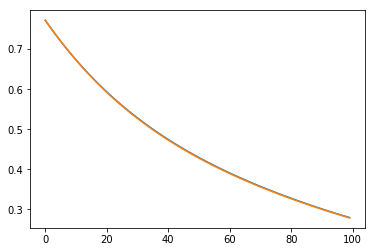

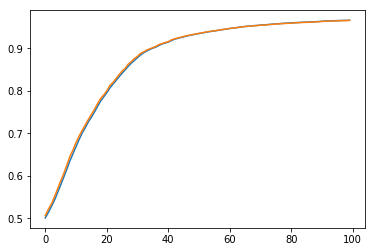

In [29]:
h = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), verbose=0, callbacks=[tensorboard])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

#### With Negatives

In [30]:
x_test, y_test = utils.create_dataset(f1.sentences_en_dev, f1,with_negatives=True)
x_test.shape, y_test.shape

((34204, 37), (34204, 39))

In [31]:
x_train, y_train = utils.create_dataset(f1.sentences_en_train, f1,with_negatives=True)
x_train.shape, y_train.shape

((100188, 37), (100188, 39))

In [32]:
model_n = keras.models.Sequential()
model_n.add(keras.layers.Dense(39, activation='sigmoid', input_dim=37))

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
opt = keras.optimizers.Adam(lr=0.0001)

model_n.compile(opt, 'binary_crossentropy', metrics=['accuracy'])
model_n.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 39)                1482      
Total params: 1,482
Trainable params: 1,482
Non-trainable params: 0
_________________________________________________________________


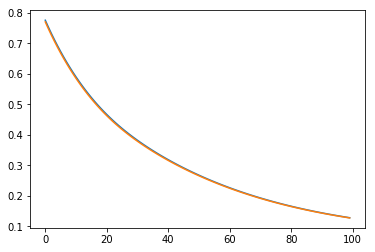

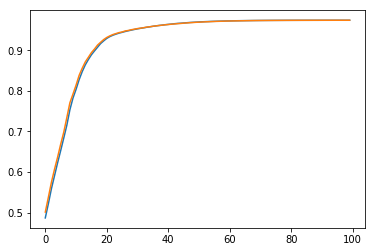

In [33]:
h = model_n.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), verbose=0, callbacks=[tensorboard])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

#### LAS Score

In [34]:
sentences_test = utils.predict_sentences("UD_English-LinES/en_lines-ud-test.conllu", f1, model=model)

utils.write_conllu(sentences_test, f1, "UD_English-LinES/en_lines-ud-test.conllu", 'en_test.conll')
utils.score_las('en_test.conll', "UD_English-LinES/en_lines-ud-test.conllu")

0.16546117903091595

In [35]:
sentences_test = utils.predict_sentences("UD_English-LinES/en_lines-ud-test.conllu", f1, model=model_n)

utils.write_conllu(sentences_test, f1, "UD_English-LinES/en_lines-ud-test.conllu", 'en_test_n.conll')
utils.score_las('en_test_n.conll', "UD_English-LinES/en_lines-ud-test.conllu")

0.13851372975740894

## F1 Dutch

In [36]:
sentence = f1.sentences_nl_dev[3]
pd.DataFrame(sentence)

,0,1,2,3
0,0,ROOT,0,root
1,1,ADP,2,case
2,2,NUM,11,obl
3,3,PROPN,2,flat:name
4,4,NUM,2,flat:name
5,5,ADP,7,case
6,6,ADJ,7,det
7,7,NOUN,2,nmod
8,8,AUX,11,cop
9,9,ADV,11,advmod


### Projectivity

In [37]:
counter_p, proportion_p = utils.count_projectives(f1.sentences_nl_train, f1)
counter_p, '%.2f %%' % proportion_p

(332, '5.74 %')

In [38]:
counter_p, proportion_p = utils.count_projectives(f1.sentences_nl_dev, f1)
counter_p, '%.2f %%' % proportion_p

(62, '9.17 %')

In [39]:
counter_p, proportion_p = utils.count_projectives(f1.sentences_nl_test, f1)
counter_p, '%.2f %%' % proportion_p

(36, '4.11 %')

### Creating Dataset

#### Without Negative 

In [40]:
x_train, y_train = utils.create_dataset(f1.sentences_nl_train, f1)
x_train.shape, y_train.shape

((75134, 37), (75134, 39))

In [41]:
x_test, y_test = utils.create_dataset(f1.sentences_nl_dev, f1)
x_train.shape, y_train.shape

((75134, 37), (75134, 39))

In [42]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(39, activation='sigmoid', input_dim=37))

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
opt = keras.optimizers.Adam(lr=0.0001)

model.compile(opt, 'binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 39)                1482      
Total params: 1,482
Trainable params: 1,482
Non-trainable params: 0
_________________________________________________________________


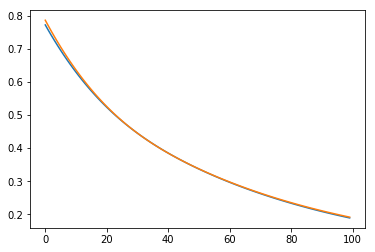

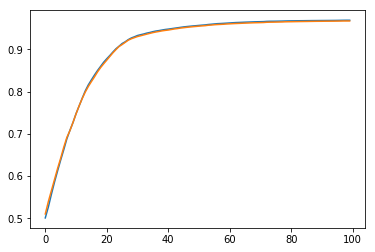

In [43]:
h = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), verbose=0, callbacks=[tensorboard])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

#### With negatives 

In [44]:
x_train, y_train = utils.create_dataset(f1.sentences_nl_train, f1,with_negatives=True)
x_train.shape, y_train.shape

((149831, 37), (149831, 39))

In [45]:
x_test, y_test = utils.create_dataset(f1.sentences_nl_dev, f1, with_negatives=True)
x_train.shape, y_train.shape

((149831, 37), (149831, 39))

In [46]:
model_n = keras.models.Sequential()
model_n.add(keras.layers.Dense(39, activation='sigmoid', input_dim=37))

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
opt = keras.optimizers.Adam(lr=0.0001)

model_n.compile(opt, 'binary_crossentropy', metrics=['accuracy'])
model_n.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 39)                1482      
Total params: 1,482
Trainable params: 1,482
Non-trainable params: 0
_________________________________________________________________


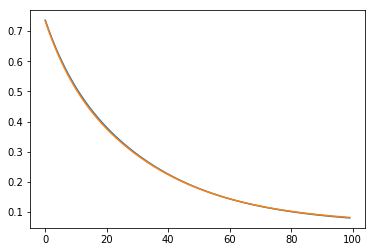

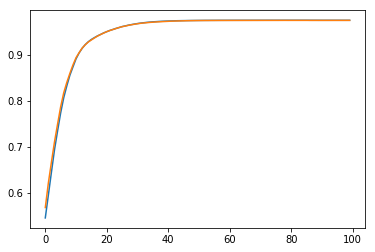

In [47]:
h = model_n.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), verbose=0, callbacks=[tensorboard])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

### LAS Scores

In [48]:
sentences_test = utils.predict_sentences("UD_Dutch-LassySmall/nl_lassysmall-ud-test.conllu", f1, model=model)

utils.write_conllu(sentences_test, f1, "UD_Dutch-LassySmall/nl_lassysmall-ud-test.conllu", 'nl_test.conll')
utils.score_las('nl_test.conll', "UD_Dutch-LassySmall/nl_lassysmall-ud-test.conllu")

0.15195231513476157

In [49]:
sentences_test = utils.predict_sentences("UD_Dutch-LassySmall/nl_lassysmall-ud-test.conllu", f1, model=model_n)

utils.write_conllu(sentences_test, f1, "UD_Dutch-LassySmall/nl_lassysmall-ud-test.conllu", 'nl_test_n.conll')
utils.score_las('nl_test_n.conll', "UD_Dutch-LassySmall/nl_lassysmall-ud-test.conllu")

0.11973047684865239

## F1 Japanese

In [50]:
sentence = f1.sentences_ja_dev[3]
pd.DataFrame(sentence)

,0,1,2,3
0,0,ROOT,0,root
1,1,NOUN,4,nmod
2,2,SYM,1,compound
3,3,NOUN,4,compound
4,4,NOUN,7,nmod
5,5,ADP,4,case
6,6,PROPN,7,compound
7,7,PROPN,9,nsubj
8,8,ADP,7,case
9,9,NOUN,0,root


### Projectivity

In [51]:
counter_p, proportion_p = utils.count_projectives(f1.sentences_ja_train, f1)
counter_p, '%.2f %%' % proportion_p

(191, '2.68 %')

In [52]:
counter_p, proportion_p = utils.count_projectives(f1.sentences_ja_dev, f1)
counter_p, '%.2f %%' % proportion_p

(13, '2.54 %')

In [53]:
counter_p, proportion_p = utils.count_projectives(f1.sentences_ja_test, f1)
counter_p, '%.2f %%' % proportion_p

(13, '2.36 %')

### Creating Dataset

#### Without Negatives

In [54]:
x_train, y_train = utils.create_dataset(f1.sentences_ja_train, f1)
x_train.shape, y_train.shape

((160419, 37), (160419, 39))

In [55]:
x_test, y_test = utils.create_dataset(f1.sentences_ja_dev, f1)
x_train.shape, y_train.shape

((160419, 37), (160419, 39))

In [56]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(39, activation='sigmoid', input_dim=37))

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
opt = keras.optimizers.Adam(lr=0.0001)

model.compile(opt, 'binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 39)                1482      
Total params: 1,482
Trainable params: 1,482
Non-trainable params: 0
_________________________________________________________________


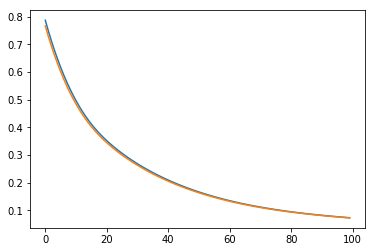

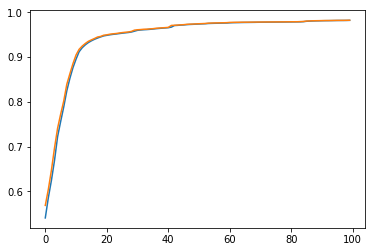

In [57]:
h = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), verbose=0, callbacks=[tensorboard])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

#### With Negatives

In [58]:
x_train, y_train = utils.create_dataset(f1.sentences_ja_train, f1, with_negatives=True)
x_train.shape, y_train.shape

((320838, 37), (320838, 39))

In [59]:
x_test, y_test = utils.create_dataset(f1.sentences_ja_dev, f1, with_negatives=True)
x_train.shape, y_train.shape

((320838, 37), (320838, 39))

In [60]:
model_n = keras.models.Sequential()
model_n.add(keras.layers.Dense(39, activation='sigmoid', input_dim=37))

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
opt = keras.optimizers.Adam(lr=0.0001)

model_n.compile(opt, 'binary_crossentropy', metrics=['accuracy'])
model_n.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 39)                1482      
Total params: 1,482
Trainable params: 1,482
Non-trainable params: 0
_________________________________________________________________


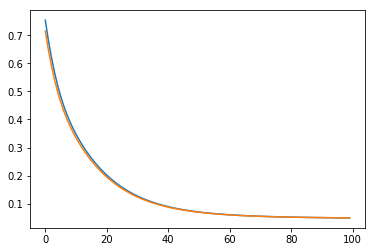

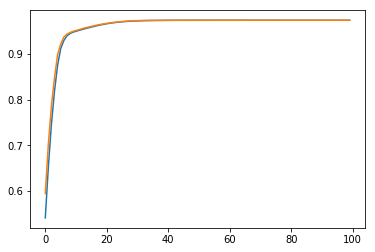

In [61]:
h = model_n.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), verbose=0, callbacks=[tensorboard])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

### LAS Score

In [62]:
sentences_test = utils.predict_sentences("UD_Japanese-GSD-master/ja_gsd-ud-test.conllu", f1, model=model)

utils.write_conllu(sentences_test, f1, "UD_Japanese-GSD-master/ja_gsd-ud-test.conllu", 'ja_test.conll')
utils.score_las('ja_test.conll', "UD_Japanese-GSD-master/ja_gsd-ud-test.conllu")

0.26507477086348286

In [63]:
sentences_test = utils.predict_sentences("UD_Japanese-GSD-master/ja_gsd-ud-test.conllu", f1, model=model_n)

utils.write_conllu(sentences_test, f1, "UD_Japanese-GSD-master/ja_gsd-ud-test.conllu", 'ja_test_n.conll')
utils.score_las('ja_test_n.conll', "UD_Japanese-GSD-master/ja_gsd-ud-test.conllu")

0.14351181862035697

## F2 features

In [64]:
sentence = f2.sentences_fr_train[3]
pd.DataFrame(sentence)

,0,1,2,3,4,5
0,0,ROOT,ROOT,_,0,root
1,1,toutefois,ADV,_,5,advmod
2,2,",",PUNCT,_,5,punct
3,3,le,DET,Definite=Def|Gender=Fem|Number=Plur|PronType=Art,4,det
4,4,fille,NOUN,Gender=Fem|Number=Plur,5,nsubj
5,5,adorer,VERB,Mood=Ind|Number=Plur|Person=3|Tense=Pres|VerbF...,0,root
6,6,le,DET,Definite=Def|Gender=Masc|Number=Plur|PronType=Art,7,det
7,7,dessert,NOUN,Gender=Masc|Number=Plur,5,obj
8,8,.,PUNCT,_,5,punct


## Morphology Exploration

In [65]:
morphos, no_morpho_count, word_count = f2.count_morphos(f2.sentences_fr_train)
no_morpho_count, word_count, '%.2f %%' % (no_morpho_count / word_count * 100)

(172186, 371192, '46.39 %')

In [66]:
inputs_count = 0
for m in morphos:
    inputs_count += len(m)
inputs_count

86

In [67]:
morphos

{'Case': Counter({'Abl': 1, 'Voc': 1}),
 'Definite': Counter({'Def': 38331, 'Ind': 9023}),
 'Degree': Counter({'Cmp': 1}),
 'Gender': Counter({'Fem': 66409, 'Masc': 89525, 'Neut': 2}),
 'Mood': Counter({'Cnd': 386, 'Imp': 109, 'Ind': 21317, 'Sub': 347}),
 'NumType': Counter({'Ord': 174}),
 'Number': Counter({'Plur': 43280, 'Sing': 140866}),
 'Person': Counter({'1': 1723, '2': 527, '3': 31007}),
 'Polarity': Counter({'Neg': 2550}),
 'Poss': Counter({'Yes': 3908}),
 'PronType': Counter({'Art': 47279,
          'Dem': 3380,
          'Ind': 3,
          'Int': 1,
          'Neg': 108,
          'Prs': 13104,
          'Rel': 3062}),
 'Reflex': Counter({'Yes': 95}),
 'Tense': Counter({'Fut': 740, 'Imp': 1812, 'Past': 12229, 'Pres': 19744}),
 'VerbForm': Counter({'Fin': 22159, 'Inf': 5511, 'Part': 12363})}

In [68]:
f2.remove_morpho(['Case', 'Degree'], f2.sentences_fr_train, morphos)

In [69]:
morphos_vec = f2.morpho_2_vec(morphos)

In [70]:
print(sentence[3][f2.morpho_i])
f2.convert_morpho(sentence[3], morphos_vec)

Definite=Def|Gender=Fem|Number=Plur|PronType=Art


array([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Embeddings

In [71]:
txts = []
for s in sentence:
    txts.append(list(s.T[lemma_i]))

NameError: name 'lemma_i' is not defined

In [ ]:
word2vec = Word2Vec(txts, size=100, window=5, min_count=1, workers=20, iter=13)

In [ ]:
word2vec.most_similar('homme')

In [ ]:
embeddings = f2.load_embedding_tsv('embeddings/fr.tsv')

In [ ]:
for w, d in f2.most_similar('homme', embeddings):
    print(w, d)

In [ ]:
for w, d in f2.most_similar('femme', embeddings):
    print(w, d)

In [ ]:
mean_embedding = f2.default_embedding(embeddings, len(embeddings['homme']))

## Data

In [ ]:
x_train, y_train = utils.create_dataset(f2.sentences_fr_train, f2, morphos_vec, embeddings, mean_embedding, with_negatives=False)
x_train.shape, y_train.shape

In [ ]:
x_test, y_test = utils.create_dataset(f2.sentences_fr_dev, f2, morphos_vec, embeddings, mean_embedding, with_negatives=False)
x_test.shape, y_test.shape

## Model

In [ ]:
modelf2 = keras.models.Sequential()
modelf2.add(keras.layers.Dense(393, activation='sigmoid', input_dim=793))
modelf2.add(keras.layers.Dense(150, activation='sigmoid'))
modelf2.add(keras.layers.Dense(39, activation='softplus'))

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
opt = keras.optimizers.Adam(lr=0.0001)

modelf2.compile(opt, 'categorical_crossentropy', metrics=['accuracy'])
modelf2.summary()

In [ ]:
h = modelf2.fit(x_train, y_train, epochs=70, batch_size=1024, validation_data=(x_test, y_test), verbose=0, callbacks=[tensorboard])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

## Eisner

In [ ]:
sentences_test = utils.predict_sentences(
    'UD_French-GSD/fr_gsd-ud-test.conllu', 
     f2, 
     morphos_vec, 
     embeddings,
     mean_embedding, 
     model=modelf2, 
     features_enabled=[0, 2, 3, 5, 6, 7], 
     root=[0, 'ROOT', 'ROOT', '_', 0, 'root']
)
utils.write_conllu(sentences_test, f2, 'UD_French-GSD/fr_gsd-ud-test.conllu', 'fr_test_f2_n.conll')
utils.score_las('fr_test_f2_n.conll', 'UD_French-GSD/fr_gsd-ud-test.conllu')

## F3 features

### French

In [20]:
morphos, no_morpho_count, word_count = f2.count_morphos(f2.sentences_fr_train)
no_morpho_count, word_count, '%.2f %%' % (no_morpho_count / word_count * 100)

(172186, 371192, '46.39 %')

In [21]:
f2.remove_morpho(['Case', 'Degree'], f2.sentences_fr_train, morphos)

In [22]:
morphos_vec = f2.morpho_2_vec(morphos)

In [23]:
embeddings = f2.load_embedding_tsv('embeddings/fr.tsv')

In [24]:
sentence = f3.sentences_fr_train[3]
pd.DataFrame(sentence)

,0,1,2,3,4,5,6,7
0,0,ROOT,ROOT,_,0,root,,ADV
1,1,toutefois,ADV,_,5,advmod,ROOT,PUNCT
2,2,",",PUNCT,_,5,punct,ADV,DET
3,3,le,DET,Definite=Def|Gender=Fem|Number=Plur|PronType=Art,4,det,PUNCT,NOUN
4,4,fille,NOUN,Gender=Fem|Number=Plur,5,nsubj,DET,VERB
5,5,adorer,VERB,Mood=Ind|Number=Plur|Person=3|Tense=Pres|VerbF...,0,root,NOUN,DET
6,6,le,DET,Definite=Def|Gender=Masc|Number=Plur|PronType=Art,7,det,VERB,NOUN
7,7,dessert,NOUN,Gender=Masc|Number=Plur,5,obj,DET,PUNCT
8,8,.,PUNCT,_,5,punct,NOUN,


In [26]:
mean_embedding = f2.default_embedding(embeddings, len(embeddings['homme']))

In [27]:
x_train, y_train = utils.create_dataset(f3.sentences_fr_train, f3, morphos_vec, embeddings, mean_embedding, False)
x_train.shape, y_train.shape

((356638, 865), (356638, 39))

In [28]:
x_test, y_test = utils.create_dataset(f3.sentences_fr_dev, f3, morphos_vec, embeddings, mean_embedding, False)
x_test.shape, y_test.shape

((35768, 865), (35768, 39))

In [29]:
x1 = keras.layers.Input(shape=(757,))
x = keras.layers.Dense(393, activation='sigmoid')(x1)

y1 = keras.layers.Input(shape=(54,))
y = keras.layers.Reshape((3, -1))(y1)

z1 = keras.layers.Input(shape=(54,))
z = keras.layers.Reshape((3, -1))(z1)
for i in range(1):
    y = keras.layers.LSTM(18,activation='sigmoid',return_sequences=True)(y)
    y = keras.layers.BatchNormalization()(y)
    z = keras.layers.LSTM(18,activation='sigmoid',recurrent_dropout=0.3,return_sequences=True)(z)
    z = keras.layers.BatchNormalization()(z)
y = keras.layers.LSTM(18,activation='sigmoid')(y)
y = keras.layers.BatchNormalization()(y)
z = keras.layers.LSTM(18,activation='sigmoid')(z)
z = keras.layers.BatchNormalization()(z)

x = keras.layers.concatenate([x, y, z])

x = keras.layers.Dense(400, activation='sigmoid')(x)
x = keras.layers.Dense(150, activation='sigmoid')(x)
x = keras.layers.Dense(39, activation='softplus')(x)

modelf3 = keras.models.Model(inputs=[x1, y1, z1], outputs=[x])

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
opt = keras.optimizers.Adam(amsgrad=True,decay=0.001)

modelf3.compile(opt, 'categorical_crossentropy', metrics=['accuracy'])
modelf3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 54)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 54)           0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 3, 18)        0           input_2[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 3, 18)        0           input_3[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LS

In [12]:
from IPython.core.display import HTML
HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
</style>
""")

In [31]:
from keras_tqdm import TQDMNotebookCallback
h = modelf3.fit([x_train[:, :757], x_train[:, 757:811], x_train[:, 811:]], y_train, 
                epochs=45, 
                batch_size=1024, 
                validation_data=([x_test[:, :757], x_test[:, 757:811], x_test[:, 811:]], y_test), 
                verbose=0, 
                callbacks=[tensorboard,TQDMNotebookCallback(leave_inner=False)])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

In [32]:
sentences_test = utils.predict_sentences(
    'UD_French-GSD/fr_gsd-ud-test.conllu', 
     f3, 
     morphos_vec, 
     embeddings,
     mean_embedding, 
     True, 
     model=modelf3, 
     features_enabled=[0, 2, 3, 5, 6, 7], 
     root=[0, 'ROOT', 'ROOT', '_', 0, 'root'],
     sentences_callback=f3.add_neighbors_pos
)
utils.write_conllu(sentences_test, f3, 'UD_French-GSD/fr_gsd-ud-test.conllu', 'fr_test_f3_n.conll')
utils.score_las('fr_test_f3_n.conll', 'UD_French-GSD/fr_gsd-ud-test.conllu')

0.6517964071856287

### English

In [2]:
morphos, no_morpho_count, word_count = f2.count_morphos(f2.sentences_en_train)
no_morpho_count, word_count, '%.2f %%' % (no_morpho_count / word_count * 100)

(21319, 52834, '40.35 %')

In [3]:
morphos_vec = f2.morpho_2_vec(morphos)

In [4]:
embeddings = f2.load_embedding_tsv('embeddings/en.tsv')

In [5]:
mean_embedding = f2.default_embedding(embeddings, len(embeddings['man']))

In [7]:
x_train, y_train = utils.create_dataset(f3.sentences_en_train, f3, morphos_vec, embeddings, mean_embedding, False)
x_train.shape, y_train.shape

((50096, 865), (50096, 39))

In [8]:
x_test, y_test = utils.create_dataset(f3.sentences_en_dev, f3, morphos_vec, embeddings, mean_embedding, False)
x_test.shape, y_test.shape

((17102, 865), (17102, 39))

In [9]:
x1 = keras.layers.Input(shape=(757,))
x = keras.layers.Dense(393, activation='sigmoid')(x1)

y1 = keras.layers.Input(shape=(54,))
y = keras.layers.Reshape((3, -1))(y1)

z1 = keras.layers.Input(shape=(54,))
z = keras.layers.Reshape((3, -1))(z1)
for i in range(1):
    y = keras.layers.LSTM(18,activation='sigmoid',return_sequences=True)(y)
    y = keras.layers.BatchNormalization()(y)
    z = keras.layers.LSTM(18,activation='sigmoid',recurrent_dropout=0.3,return_sequences=True)(z)
    z = keras.layers.BatchNormalization()(z)
y = keras.layers.LSTM(18,activation='sigmoid')(y)
y = keras.layers.BatchNormalization()(y)
z = keras.layers.LSTM(18,activation='sigmoid')(z)
z = keras.layers.BatchNormalization()(z)

x = keras.layers.concatenate([x, y, z])

x = keras.layers.Dense(400, activation='sigmoid')(x)
x = keras.layers.Dense(150, activation='sigmoid')(x)
x = keras.layers.Dense(39, activation='softplus')(x)

modelf3 = keras.models.Model(inputs=[x1, y1, z1], outputs=[x])

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
opt = keras.optimizers.Adam(amsgrad=True,decay=0.001)

modelf3.compile(opt, 'categorical_crossentropy', metrics=['accuracy'])
modelf3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 54)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 54)           0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 3, 18)        0           input_2[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 3, 18)        0           input_3[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LS

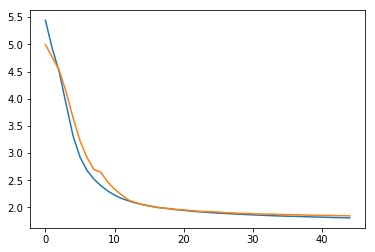

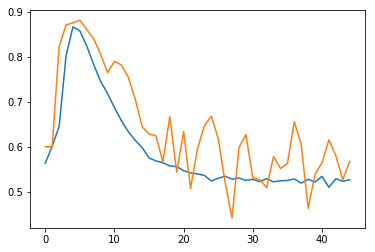

In [10]:
from keras_tqdm import TQDMNotebookCallback
h = modelf3.fit([x_train[:, :757], x_train[:, 757:811], x_train[:, 811:]], y_train, 
                epochs=45, 
                batch_size=1024, 
                validation_data=([x_test[:, :757], x_test[:, 757:811], x_test[:, 811:]], y_test), 
                verbose=0, 
                callbacks=[tensorboard,TQDMNotebookCallback(leave_inner=False)])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

In [11]:
sentences_test = utils.predict_sentences(
    "UD_English-LinES/en_lines-ud-test.conllu", 
     f3, 
     morphos_vec, 
     embeddings,
     mean_embedding, 
     True, 
     model=modelf3, 
     features_enabled=[0, 2, 3, 5, 6, 7], 
     root=[0, 'ROOT', 'ROOT', '_', 0, 'root'],
     sentences_callback=f3.add_neighbors_pos
)
utils.write_conllu(sentences_test, f3, "UD_English-LinES/en_lines-ud-test.conllu", 'en_test_f3_n.conll')
utils.score_las('en_test_f3_n.conll', "UD_English-LinES/en_lines-ud-test.conllu")

0.5131536836715099

### Dutch

In [13]:
morphos, no_morpho_count, word_count = f2.count_morphos(f2.sentences_nl_train)
no_morpho_count, word_count, '%.2f %%' % (no_morpho_count / word_count * 100)

(41380, 80923, '51.14 %')

In [14]:
morphos_vec = f2.morpho_2_vec(morphos)

In [15]:
embeddings = f2.load_embedding_tsv('embeddings/nl.tsv')

In [16]:
mean_embedding = f2.default_embedding(embeddings, len(embeddings['man']))

In [17]:
x_train, y_train = utils.create_dataset(f3.sentences_nl_train, f3, morphos_vec, embeddings, mean_embedding, False)
x_train.shape, y_train.shape

((75134, 865), (75134, 39))

In [19]:
x_test, y_test = utils.create_dataset(f3.sentences_nl_dev, f3, morphos_vec, embeddings, mean_embedding, False)
x_test.shape, y_test.shape

((11397, 865), (11397, 39))

In [20]:
x1 = keras.layers.Input(shape=(757,))
x = keras.layers.Dense(393, activation='sigmoid')(x1)

y1 = keras.layers.Input(shape=(54,))
y = keras.layers.Reshape((3, -1))(y1)

z1 = keras.layers.Input(shape=(54,))
z = keras.layers.Reshape((3, -1))(z1)
for i in range(1):
    y = keras.layers.LSTM(18,activation='sigmoid',return_sequences=True)(y)
    y = keras.layers.BatchNormalization()(y)
    z = keras.layers.LSTM(18,activation='sigmoid',recurrent_dropout=0.3,return_sequences=True)(z)
    z = keras.layers.BatchNormalization()(z)
y = keras.layers.LSTM(18,activation='sigmoid')(y)
y = keras.layers.BatchNormalization()(y)
z = keras.layers.LSTM(18,activation='sigmoid')(z)
z = keras.layers.BatchNormalization()(z)

x = keras.layers.concatenate([x, y, z])

x = keras.layers.Dense(400, activation='sigmoid')(x)
x = keras.layers.Dense(150, activation='sigmoid')(x)
x = keras.layers.Dense(39, activation='softplus')(x)

modelf3 = keras.models.Model(inputs=[x1, y1, z1], outputs=[x])

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
opt = keras.optimizers.Adam(amsgrad=True,decay=0.001)

modelf3.compile(opt, 'categorical_crossentropy', metrics=['accuracy'])
modelf3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 54)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 54)           0                                            
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 3, 18)        0           input_5[0][0]                    
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 3, 18)        0           input_6[0][0]                    
__________________________________________________________________________________________________
lstm_5 (LS

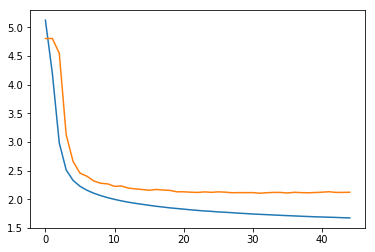

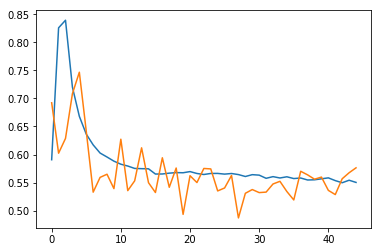

In [21]:
from keras_tqdm import TQDMNotebookCallback
h = modelf3.fit([x_train[:, :757], x_train[:, 757:811], x_train[:, 811:]], y_train, 
                epochs=45, 
                batch_size=1024, 
                validation_data=([x_test[:, :757], x_test[:, 757:811], x_test[:, 811:]], y_test), 
                verbose=0, 
                callbacks=[tensorboard,TQDMNotebookCallback(leave_inner=False)])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

In [22]:
sentences_test = utils.predict_sentences(
    "UD_Dutch-LassySmall/nl_lassysmall-ud-test.conllu", 
     f3, 
     morphos_vec, 
     embeddings,
     mean_embedding, 
     True, 
     model=modelf3, 
     features_enabled=[0, 2, 3, 5, 6, 7], 
     root=[0, 'ROOT', 'ROOT', '_', 0, 'root'],
     sentences_callback=f3.add_neighbors_pos
)
utils.write_conllu(sentences_test, f3, "UD_Dutch-LassySmall/nl_lassysmall-ud-test.conllu", 'nl_test_f3_n.conll')
utils.score_las('nl_test_f3_n.conll', "UD_Dutch-LassySmall/nl_lassysmall-ud-test.conllu")

0.4837595024187975

### Japanese

In [23]:
morphos, no_morpho_count, word_count = f2.count_morphos(f2.sentences_ja_train)
no_morpho_count, word_count, '%.2f %%' % (no_morpho_count / word_count * 100)

(163678, 167552, '97.69 %')

In [24]:
morphos_vec = f2.morpho_2_vec(morphos)

0.6028942115768463

In [25]:
embeddings = f2.load_embedding_tsv('embeddings/ja.tsv')

In [26]:
mean_embedding = f2.default_embedding(embeddings, len(embeddings['の']))

In [29]:
x_train, y_train = utils.create_dataset(f3.sentences_ja_train, f3, morphos_vec, embeddings, mean_embedding, False)
x_train.shape, y_train.shape

((160419, 865), (160419, 39))

In [30]:
x_test, y_test = utils.create_dataset(f3.sentences_ja_dev, f3, morphos_vec, embeddings, mean_embedding, False)
x_test.shape, y_test.shape

((11491, 865), (11491, 39))

In [31]:
x1 = keras.layers.Input(shape=(757,))
x = keras.layers.Dense(393, activation='sigmoid')(x1)

y1 = keras.layers.Input(shape=(54,))
y = keras.layers.Reshape((3, -1))(y1)

z1 = keras.layers.Input(shape=(54,))
z = keras.layers.Reshape((3, -1))(z1)
for i in range(1):
    y = keras.layers.LSTM(18,activation='sigmoid',return_sequences=True)(y)
    y = keras.layers.BatchNormalization()(y)
    z = keras.layers.LSTM(18,activation='sigmoid',recurrent_dropout=0.3,return_sequences=True)(z)
    z = keras.layers.BatchNormalization()(z)
y = keras.layers.LSTM(18,activation='sigmoid')(y)
y = keras.layers.BatchNormalization()(y)
z = keras.layers.LSTM(18,activation='sigmoid')(z)
z = keras.layers.BatchNormalization()(z)

x = keras.layers.concatenate([x, y, z])

x = keras.layers.Dense(400, activation='sigmoid')(x)
x = keras.layers.Dense(150, activation='sigmoid')(x)
x = keras.layers.Dense(39, activation='softplus')(x)

modelf3 = keras.models.Model(inputs=[x1, y1, z1], outputs=[x])

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
opt = keras.optimizers.Adam(amsgrad=True,decay=0.001)

modelf3.compile(opt, 'categorical_crossentropy', metrics=['accuracy'])
modelf3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 54)           0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 54)           0                                            
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 3, 18)        0           input_8[0][0]                    
__________________________________________________________________________________________________
reshape_6 (Reshape)             (None, 3, 18)        0           input_9[0][0]                    
__________________________________________________________________________________________________
lstm_9 (LS

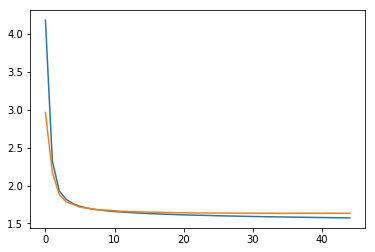

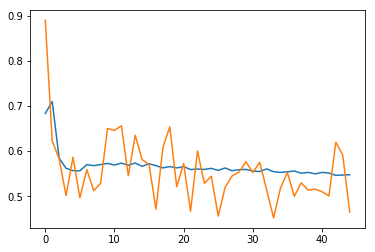

In [32]:
from keras_tqdm import TQDMNotebookCallback
h = modelf3.fit([x_train[:, :757], x_train[:, 757:811], x_train[:, 811:]], y_train, 
                epochs=45, 
                batch_size=1024, 
                validation_data=([x_test[:, :757], x_test[:, 757:811], x_test[:, 811:]], y_test), 
                verbose=0, 
                callbacks=[tensorboard,TQDMNotebookCallback(leave_inner=False)])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

In [33]:
sentences_test = utils.predict_sentences(
    "UD_Japanese-GSD-master/ja_gsd-ud-test.conllu", 
     f3, 
     morphos_vec, 
     embeddings,
     mean_embedding, 
     True, 
     model=modelf3, 
     features_enabled=[0, 2, 3, 5, 6, 7], 
     root=[0, 'ROOT', 'ROOT', '_', 0, 'root'],
     sentences_callback=f3.add_neighbors_pos
)
utils.write_conllu(sentences_test, f3, "UD_Japanese-GSD-master/ja_gsd-ud-test.conllu", 'ja_test_f3_n.conll')
utils.score_las('ja_test_f3_n.conll', "UD_Japanese-GSD-master/ja_gsd-ud-test.conllu")

0.7305032963498955